In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import warnings
warnings.filterwarnings("ignore")

In [2]:
from matplotlib import colors as colors
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)
 
cmap_data = [(0, rgb2hex(130, 90, 80)), \
             (0.0625, rgb2hex(150, 110, 100)), \
             (0.125, rgb2hex(170, 130, 120)), \
             (0.1875, rgb2hex(180, 140, 130)), \
             (0.25, rgb2hex(190, 150, 140)), \
             (0.3125, rgb2hex(200, 160, 150)), \
             (0.375, rgb2hex(220, 185, 175)), \
             (0.475, rgb2hex(240, 215, 210)), \
             (0.495, rgb2hex(255, 255, 255)), \
             (0.505, rgb2hex(255, 255, 255)), \
             (0.525, rgb2hex(210, 255, 215)), \
             (0.5625, rgb2hex(150, 230, 155)), \
             (0.625, rgb2hex(110, 210, 115)), \
             (0.6875, rgb2hex(45, 180, 50)), \
             (0.75, rgb2hex(20, 170, 25)), \
             (0.8125, rgb2hex(10, 150, 15)), \
             (0.875, rgb2hex(0, 130, 5)), \
             (1,rgb2hex(0, 110, 4))]
cmap = colors.LinearSegmentedColormap.from_list('prcp_anomaly', cmap_data)
plt.register_cmap('prcp_anomaly', cmap)

In [3]:
# GOGA Mean Precipitation
jvarlist=['PRECC', 'PRECL']
filelist = [f'/d1/DataCatalog/ClimateGroup/PROJECTS/CCM3/goga/atm-mean/SLD/{var}.nc' for var in jvarlist]
dsp = xr.open_mfdataset(filelist,decode_times=False).rename({'lat':'Y'}).rename({'lon':'X'}).sortby('Y').rename({'T':'time'}).sel(Y=slice(-10,70))
dsp['time'] = pd.date_range('1856-01',periods=len(dsp.time), freq='MS').shift(15,freq='D')
dsp = dsp.sel(time=slice('1979-01','2021-02'))
dsp.coords['X'] = (dsp.coords['X'] - 30) % 360 + 30; dsp = dsp.sortby('X')
dsp['Psum'] = (dsp.PRECC + dsp.PRECL) * 1000 * 86400   
ds_rain_anom = dsp.groupby('time.month').apply(lambda x: x - x.mean('time'))

In [4]:
# GOGA Geopotential height at 700mb

dsz = xr.open_dataset('/d1/DataCatalog/ClimateGroup/PROJECTS/CCM3/goga/atm-mean/PLD/Z3.nc',decode_times=False).sel(P=700, method='nearest').drop(['P']).sortby('Y').rename({'T':'time'}).sel(Y=slice(-10,70))
print(dsz)
dsz.coords['X'] = (dsz.coords['X'] - 30) % 360 + 30 ; dsz = dsz.sortby('X')
dsz['time'] = pd.date_range('1856-01',periods=len(dsz.time), freq='MS').shift(15,freq='D')
dsz = dsz.sel(time=slice('1979-01','2021-02'))
ds_z700_anom = dsz.groupby('time.month').apply(lambda x: x - x.mean('time'))

<xarray.Dataset>
Dimensions:  (time: 1984, Y: 29, X: 128)
Coordinates:
  * time     (time) float32 -1.248e+03 -1.246e+03 -1.246e+03 ... 734.5 735.5
  * Y        (Y) float32 -9.767 -6.977 -4.186 -1.395 ... 60.0 62.79 65.58 68.37
  * X        (X) float32 0.0 2.812 5.625 8.438 11.25 ... 348.8 351.6 354.4 357.2
Data variables:
    Z3       (time, Y, X) float32 ...


Input files: -
Processing: -
Calculating Bounding Box...ready. %%BoundingBox: 55 312 537 447
Creating output file - ... ready.
Input files: -
Processing: -
Calculating Bounding Box...ready. %%BoundingBox: 55 312 537 449
Creating output file - ... ready.
Input files: -
Processing: -
Calculating Bounding Box...ready. %%BoundingBox: 55 312 537 447
Creating output file - ... ready.


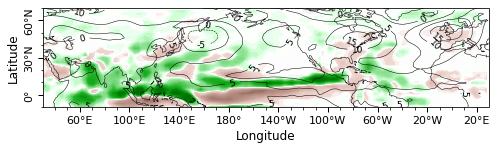

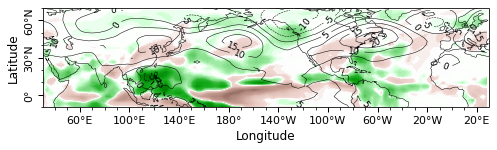

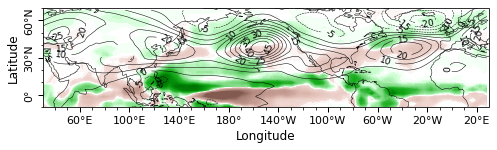

In [5]:
# T 3 boxAverage, starting with 3rd month (March 1979)
ds_rain = ds_rain_anom.Psum[2:].coarsen(time=3,boundary='trim').mean()
ds_z700 = ds_z700_anom.Z3[2:].coarsen(time=3,boundary='trim').mean()

for month in ['2020-07','2020-10','2021-01']:
    fig = plt.figure(figsize=(8,4))

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=210))
    ax.set_extent([30, 390, -10,  70], crs=ccrs.PlateCarree())

    rain = ds_rain.sel(time=f'{month}').squeeze().drop(['time'])
    z700 = ds_z700.sel(time=f'{month}').squeeze().drop(['time'])
    

    cb2 = rain.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-5,vmax=5, levels=101, cmap='prcp_anomaly', add_colorbar=False)
    # put zorder=10 to put the contours on TOP
    CS  = z700.plot.contour (ax=ax, colors= 'k', linewidths=0.5, transform=ccrs.PlateCarree(),zorder=10, vmin=-160,vmax=160,levels=65)
    ax.clabel(CS, inline=1, fontsize=9, fmt='%1.0f')
    CS.collections[16].set_linewidth(1.5) # plot the zero line thicker

    # Add coasts
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    
    # Label x-axis and make tick labels
    ax.xaxis.set_label_text('Longitude',fontsize=12)
    ax.set_xticks(np.arange(-180,179,40), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter())
    ax.xaxis.set_minor_locator(MultipleLocator(10))

    # Label y-axis and make tick labels
    ax.yaxis.set_label_text('Latitude',fontsize=12)
    plt.yticks(np.arange(0,70,30), rotation=90, va='center')
    ax.yaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter())
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    
    # Make tick marks
    ax.tick_params(which='major', width=1.00, length=5, labelsize=11)
    ax.tick_params(which='minor', width=0.75, length=2.5)

    # do some cropping of the eps file so that we can use it in latex
    plt.savefig('plot.eps')
    os.system(f'/usr/bin/ps2eps -B -C < plot.eps > eps/GOGANOAA2_{month}.eps');

Input files: -
Processing: -
Calculating Bounding Box...ready. %%BoundingBox: 137 270 482 321
Creating output file - ... ready.


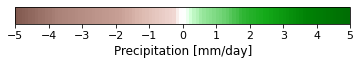

In [6]:
ds_cutclip=np.clip(ds_rain[0],-5,5)
cb = ds_cutclip.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-5,vmax=5, levels=101, cmap='prcp_anomaly', add_colorbar=False)
plt.gca().set_visible(False)
a = np.arange(-5,5.1,1)
cbar = plt.colorbar(cb, extendrect = True, orientation='horizontal', ticks=a)
cbar.ax.tick_params(labelsize=11)
cbar.set_label(label='Precipitation [mm/day]', size=12)
plt.savefig('plot.eps')
os.system(f'/usr/bin/ps2eps -B -C < plot.eps > eps/rain-colorbar5.eps');